# Structural Stress Regimes in Indian Banking (1996–2024)

### A Change-Point Analysis of Asset Quality & Loss Absorption

### 1. Problem Statement

India’s banking system stability is closely linked to Non-Performing Assets (NPAs).

Sudden increases in NPAs often indicate systemic stress that impacts:

Lending capacity

Economic growth

Financial trust

This project analyzes long-term NPA trends across bank groups and applies **change-point detection to identify structural stress regimes**.

### 2. Dataset Source

**Source:** Reserve Bank of India (RBI) – Database on Indian Economy (DBIE)

**Dataset:** Gross and Net NPAs of Scheduled Commercial Banks – Bank Group-Wise

**Time Period:** 1996 – 2023

**Frequency:** Annual

**Unit:** ₹ Crores

#### 3. Data Preparation

##### Load Raw RBI Dataset

In [113]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl") # ignore UserWarning 


file_path = r"../data/Gross and Net NPAs of Scheduled Commercial Banks - Bank Group-Wise.xlsx"

raw_df = pd.read_excel(file_path, header=None)


raw_df.head()

,0,1,2,3,4,5,6,7,8,9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Gross and Net NPAs of Scheduled Commercial Ban...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,(₹ Crores),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Clean & Structure Data

In [114]:
# Remove margin column and blank rows
raw_df = raw_df.drop(raw_df.columns[0], axis=1)
raw_df = raw_df.dropna(how='all')

# Remove Tilele and metadata rows(1st two rows)
raw_df = raw_df.iloc[2:].reset_index(drop=True)

# Remove Footer Notes
raw_df = raw_df[
    ~raw_df.iloc[:, 0].astype(str).str.contains("Notes", na=False)
]

In [115]:
raw_df.tail()

,1,2,3,4,5,6,7,8,9
162,2022-23,184808.07,177887.3876,8608.185942,4.657906,3.2,1622.429576,0.912054,0.6
163,2021-22,140002.94,135802.3508,6910.503068,4.93597,3.4,2724.559342,2.006268,1.3
164,2020-21,111589,108613,5971,5.4,3.7,2981,2.7,1.8
165,2019-20,91509,90554,1709,1.9,1.3,765,0.8,0.6
166,2018-19,62775,59461,1087,1.7,1.3,586,1,0.7


##### Extract Individual Bank Tables

There are multiple Tables for Bank Groups stacked vertically.

In [116]:
# Identify rows containing Bank Group Names
bank_start_rows = raw_df[
    raw_df.iloc[:, 0].astype(str).str.contains("Banks", na=False)
].index.tolist()
bank_start_rows

[0, 33, 66, 90, 123, 156]

In [117]:
for i in bank_start_rows:
    print(i, "->", raw_df.iloc[i, 0])

0 -> Scheduled Commercial Banks
33 -> Public Sector Banks
66 -> Old Private Sector Banks
90 -> Private Sector Banks *
123 -> Foreign Banks In India
156 -> Small Finance Banks


In [118]:
# Add end boundary for last table 
bank_start_rows.append(len(raw_df))
bank_start_rows

[0, 33, 66, 90, 123, 156, 167]

In [119]:
bank_tables = {}

for i in range(len(bank_start_rows) - 1):

    start = bank_start_rows[i]
    end = bank_start_rows[i + 1]

    bank_name = raw_df.iloc[start, 0]

    table_df = raw_df.iloc[start:end].reset_index(drop=True)

    bank_tables[bank_name] = table_df

bank_tables.keys()

dict_keys(['Scheduled Commercial Banks', 'Public Sector Banks', 'Old Private Sector Banks', 'Private Sector Banks *', 'Foreign Banks In India', 'Small Finance Banks'])

In [120]:
clean_tables = []

columns = [
    "Year",
    "Advances_Gross",
    "Advances_Net",
    "Gross_NPA_Amount",
    "Gross_NPA_pct_Gross_Adv",
    "Gross_NPA_pct_Total_Assets",
    "Net_NPA_Amount",
    "Net_NPA_pct_Net_Adv",
    "Net_NPA_pct_Total_Assets"
]

for bank_name, df in bank_tables.items():

    # Remove 5 header rows
    df_clean = df.iloc[5:].copy()
    df_clean.columns = columns

    # Add bank type
    df_clean["Bank_Type"] = bank_name

    clean_tables.append(df_clean)

In [121]:
# Merge All Bank Tables
master_df = pd.concat(clean_tables, ignore_index=True)

In [122]:
master_df.head()

,Year,Advances_Gross,Advances_Net,Gross_NPA_Amount,Gross_NPA_pct_Gross_Adv,Gross_NPA_pct_Total_Assets,Net_NPA_Amount,Net_NPA_pct_Net_Adv,Net_NPA_pct_Total_Assets,Bank_Type
0,2023-24,17508589.83,17142339.56,480818.2938,2.746185,1.7,106732.3205,0.622624,0.4,Scheduled Commercial Banks
1,2022-23,14756637.36,14319352.43,571545.5407,3.873142,2.4,135319.7062,0.945013,0.6,Scheduled Commercial Banks
2,2021-22,12750005.88,12198767.37,743639.6871,5.832465,3.4,204230.9038,1.674193,0.9,Scheduled Commercial Banks
3,2020-21,11399608,10806381,835138,7.3,4.3,258050,2.4,1.3,Scheduled Commercial Banks
4,2019-20,10918918,10301897,899803,8.2,5,289370,2.8,1.6,Scheduled Commercial Banks


In [123]:
master_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Year                        137 non-null    object
 1   Advances_Gross              135 non-null    object
 2   Advances_Net                135 non-null    object
 3   Gross_NPA_Amount            135 non-null    object
 4   Gross_NPA_pct_Gross_Adv     135 non-null    object
 5   Gross_NPA_pct_Total_Assets  135 non-null    object
 6   Net_NPA_Amount              135 non-null    object
 7   Net_NPA_pct_Net_Adv         135 non-null    object
 8   Net_NPA_pct_Total_Assets    135 non-null    object
 9   Bank_Type                   137 non-null    str   
dtypes: object(9), str(1)
memory usage: 10.8+ KB


##### Final Structured Dataset

In [124]:
master_df["Year"] = master_df["Year"].str.extract(r"(\d{4})").astype(int)

num_cols = master_df.columns.drop(["Year", "Bank_Type"])
for col in num_cols:
    master_df[col] = pd.to_numeric(master_df[col], errors="coerce")

master_df = master_df.dropna(subset=["Advances_Gross", "Gross_NPA_Amount"])
master_df = master_df.reset_index(drop=True)

In [125]:
master_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        135 non-null    int64  
 1   Advances_Gross              135 non-null    float64
 2   Advances_Net                135 non-null    float64
 3   Gross_NPA_Amount            135 non-null    float64
 4   Gross_NPA_pct_Gross_Adv     135 non-null    float64
 5   Gross_NPA_pct_Total_Assets  135 non-null    float64
 6   Net_NPA_Amount              135 non-null    float64
 7   Net_NPA_pct_Net_Adv         135 non-null    float64
 8   Net_NPA_pct_Total_Assets    135 non-null    float64
 9   Bank_Type                   135 non-null    str    
dtypes: float64(8), int64(1), str(1)
memory usage: 10.7 KB


##### Dataset Summary:
- 135 total observations
- 6 bank categories
- No missing values
- Numeric columns correctly formatted
- Ready for time-series analysis
- Time Period: 1996 – 2024

In [126]:
master_df['Bank_Type'].value_counts()

Bank_Type
Scheduled Commercial Banks    28
Public Sector Banks           28
Private Sector Banks *        28
Foreign Banks In India        28
Old Private Sector Banks      17
Small Finance Banks            6
Name: count, dtype: int64

##### Bank Categories Included
- Scheduled Commercial Banks  
- Public Sector Banks  
- Old Private Sector Banks  
- Private Sector Banks  
- Foreign Banks in India  
- Small Finance Banks 

In [127]:
master_df['Year'].min(), master_df['Year'].max()

(np.int64(1996), np.int64(2023))

#### 4. Trend Analysis

Time Period (1196 - 2023)

The dataset spans multiple financial years, allowing for:
- Long-term trend analysis
- Identification of stress and recovery phases
- Cross-bank comparison over the same economic cycles

##### Gross NPA Ratio

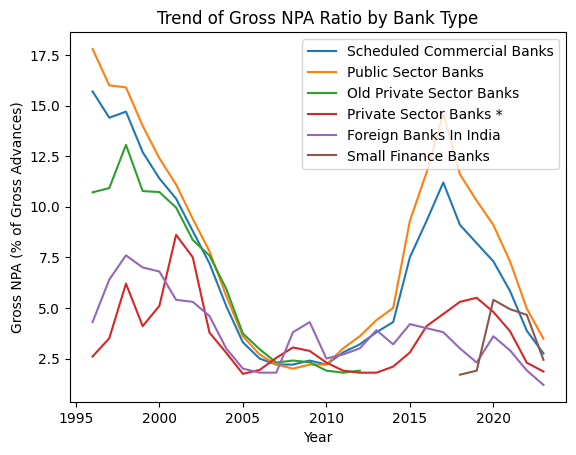

In [128]:
# Trend Analysis: Gross NPA Ratio
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
for bank in master_df['Bank_Type'].unique():
    subset = master_df[master_df['Bank_Type'] == bank]
    plt.plot(subset['Year'], subset['Gross_NPA_pct_Gross_Adv'], label=bank)

plt.xlabel("Year")
plt.ylabel("Gross NPA (% of Gross Advances)")
plt.title("Trend of Gross NPA Ratio by Bank Type")
plt.legend()
plt.show()

##### Interpretation

- Public Sector Banks show consistently higher NPAs.
- Private and Foreign Banks maintain lower NPA levels.
- The late 1990s show elevated stress across bank types.
- The post-2000 period shows long-term moderation.
- The 2015–2018 period shows stress, but trend reverts afterward.

##### Net NPA Ratio

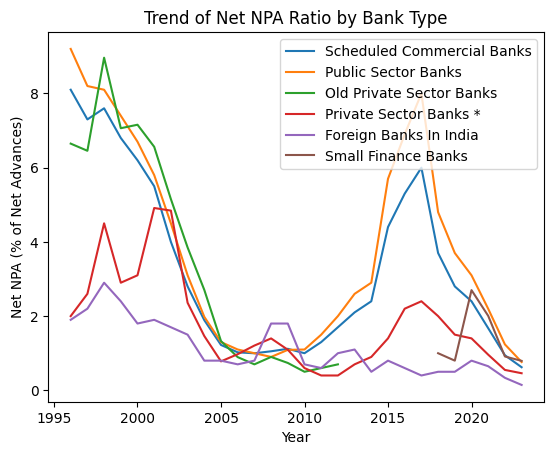

In [129]:
# Trend Analysis: Net NPA Ratio
plt.figure()
for bank in master_df['Bank_Type'].unique():
    subset = master_df[master_df['Bank_Type'] == bank]
    plt.plot(subset['Year'], subset['Net_NPA_pct_Net_Adv'], label=bank)

plt.xlabel("Year")
plt.ylabel("Net NPA (% of Net Advances)")
plt.title("Trend of Net NPA Ratio by Bank Type")
plt.legend()
plt.show()

##### Interpretation

- Net NPAs are consistently lower than Gross NPAs.
- The gap reflects provisioning buffers.
- Over time, provisioning discipline improves.
- Stress spikes appear shorter in duration compared to Gross NPAs.

#### 5. Comparative Analysis

In [130]:
# Comparison of Gross vs Net NPAs

comparison_df = master_df.groupby('Bank_Type')[[
    'Gross_NPA_pct_Gross_Adv',
    'Net_NPA_pct_Net_Adv'
]].mean()

comparison_df

,Gross_NPA_pct_Gross_Adv,Net_NPA_pct_Net_Adv
Bank_Type,,
Foreign Banks In India,3.796437,1.129724
Old Private Sector Banks,6.315758,3.583401
Private Sector Banks *,3.621413,1.785831
Public Sector Banks,7.972908,3.816704
Scheduled Commercial Banks,6.941135,3.283848
Small Finance Banks,3.504369,1.368743


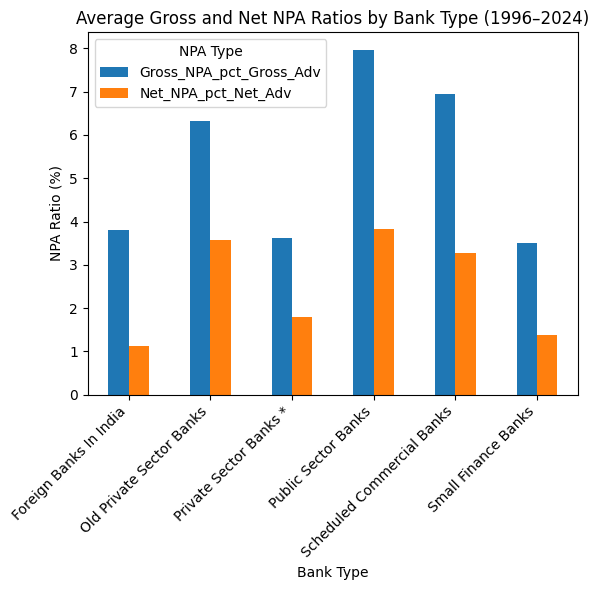

In [131]:
# Bar Chart: Average Gross vs Net NPA Ratios by Bank Type
comparison_df.plot(kind="bar", figsize=(6, 6))

plt.title("Average Gross and Net NPA Ratios by Bank Type (1996–2024)")
plt.ylabel("NPA Ratio (%)")
plt.xlabel("Bank Type")
plt.xticks(rotation=45, ha="right")
plt.legend(title="NPA Type")
plt.tight_layout()
plt.show()

##### Key Observation

- Public Sector Banks have highest long-term averages.
- Private and Foreign Banks show structurally lower averages.
- Small Finance Banks show moderate levels (short history).

#### 6. Volatility Analysis of NPA Ratios

Volatility is measured using standard deviation.
Higher volatility indicates greater sensitivity to economic and credit cycles.

In [133]:
# Volatility (standard deviation) of NPA ratios by bank type
volatility_df = master_df.groupby("Bank_Type")[
    ["Gross_NPA_pct_Gross_Adv", "Net_NPA_pct_Net_Adv"]
].std()

volatility_df

,Gross_NPA_pct_Gross_Adv,Net_NPA_pct_Net_Adv
Bank_Type,,
Foreign Banks In India,1.683121,0.718303
Old Private Sector Banks,4.102727,3.023855
Private Sector Banks *,1.801821,1.296520
Public Sector Banks,4.923086,2.739198
Scheduled Commercial Banks,4.269306,2.384616
Small Finance Banks,1.670481,0.797103


##### Interpretation

- Public Sector Banks show highest volatility.
- System-level volatility reflects PSB dominance.
- Private and Foreign Banks show relatively stable patterns.
- Small Finance Banks have shorter history; interpret cautiously.

#### 7. Structural Break Analysis (Change-Point Detection)

Trend analysis shows overall direction, while change-point detection identifies statistically significant regime shifts in the time series.

The PELT algorithm with an RBF cost model is used to detect structural breaks.
An optimal penalty value of 3 was selected after comparing multiple penalties and choosing the smallest value that produced stable and interpretable breakpoints.

##### A. Public Sector Banks

In [76]:
psb_df = master_df[master_df["Bank_Type"] == "Public Sector Banks"].sort_values("Year")

psb_df[["Year", "Gross_NPA_pct_Gross_Adv"]].head()

,Year,Gross_NPA_pct_Gross_Adv
55,1996,17.8
54,1997,16.0
53,1998,15.9
52,1999,14.0
51,2000,12.4


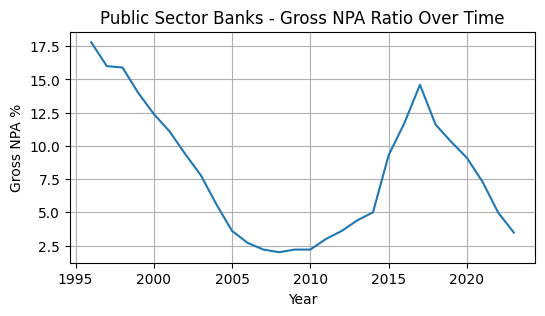

In [77]:
# Visually Identify Change-Point Detection (Public Sector Banks)

# Examine the time-series visually to identify periods where the NPA trend direction or slope changes significantly.

import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))

plt.plot(psb_df["Year"], psb_df["Gross_NPA_pct_Gross_Adv"])

plt.title("Public Sector Banks - Gross NPA Ratio Over Time")
plt.xlabel("Year")
plt.ylabel("Gross NPA %")

plt.grid(True)
plt.show()

In [ ]:
# Statistical Change-Point Detection (Public Sector Banks)

import ruptures as rpt
import numpy as np

# Prepare the signal
signal_gross_public = psb_df["Gross_NPA_pct_Gross_Adv"].values

# Change-point detection using PELT
algo_gross = rpt.Pelt(model="rbf").fit(signal_gross_public)

# Detect breakpoints
# Penalty selected as the smallest value that yields stable and interpretable breakpoints
breakpoints_gross = algo_gross.predict(pen=3)

breakpoints_gross

[5, 28]

In [79]:
psb_df.iloc[5-1]["Year"]

np.int64(2000)

##### Change-Point Detection (Net NPA)

In [80]:
# Change-Point Detection (Net NPA)

signal_net_public = psb_df["Net_NPA_pct_Net_Adv"].values
signal_net_public

array([9.2     , 8.2     , 8.1     , 7.4     , 6.7     , 5.8     ,
       4.5     , 3.1     , 1.98    , 1.3     , 1.1     , 1.      ,
       0.9     , 1.09    , 1.1     , 1.5     , 2.      , 2.6     ,
       2.9     , 5.7     , 6.9     , 8.      , 4.8     , 3.7     ,
       3.1     , 2.196858, 1.237741, 0.763111])

In [81]:
public_algo_net = rpt.Pelt(model="rbf").fit(signal_net_public)

breakpoints_public_net = public_algo_net.predict(pen=3)

breakpoints_public_net

[5, 28]

In [82]:
psb_df.iloc[breakpoints_public_net[0]-1]["Year"]

np.int64(2000)

#### Result

Structural break detected around 2000 (Gross & Net NPAs) for Public Sector Banks.

#### Interpretation

- Indicates structural shift in asset quality recognition.
- Post-2000 regime shows different NPA behavior pattern.
- Later spikes appear cyclical rather than structural.

#### B. Private Sector Banks

In [83]:
pvt_df = master_df[master_df["Bank_Type"] == "Private Sector Banks *"].sort_values("Year")

pvt_df[["Year", "Gross_NPA_pct_Gross_Adv"]].head()

,Year,Gross_NPA_pct_Gross_Adv
100,1996,2.6
99,1997,3.5
98,1998,6.2
97,1999,4.1
96,2000,5.1


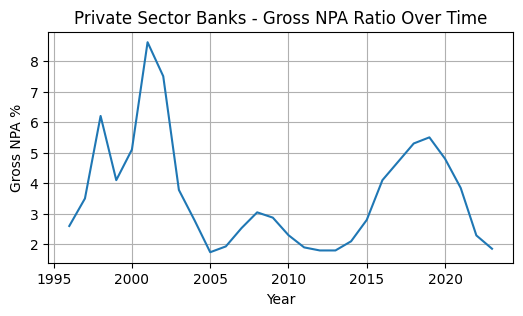

In [84]:
# Visually Identify Change-Point Detection (Private Sector Banks)

plt.figure(figsize=(6,3))

plt.plot(pvt_df["Year"], pvt_df["Gross_NPA_pct_Gross_Adv"])

plt.title("Private Sector Banks - Gross NPA Ratio Over Time")
plt.xlabel("Year")
plt.ylabel("Gross NPA %")

plt.grid(True)
plt.show()

In [85]:
# Statistical Change-Point Detection (Private Sector Banks)

signal_pvt = pvt_df["Gross_NPA_pct_Gross_Adv"].values

algo_pvt = rpt.Pelt(model="rbf").fit(signal_pvt)

breakpoints_pvt_gross = algo_pvt.predict(pen=3)

breakpoints_pvt_gross

[28]

##### Change-Point Detection (Net NPA)

In [86]:
# Change-Point Detection (Net NPA)

signal_net_pvt = pvt_df["Net_NPA_pct_Net_Adv"].values
signal_net_pvt

array([2.      , 2.6     , 4.5     , 2.9     , 3.1     , 4.91315 ,
       4.84276 , 2.35959 , 1.46291 , 0.78042 , 0.97432 , 1.20645 ,
       1.39866 , 1.09416 , 0.6     , 0.4     , 0.4     , 0.7     ,
       0.9     , 1.4     , 2.2     , 2.4     , 2.      , 1.5     ,
       1.4     , 0.960533, 0.549872, 0.460454])

In [87]:
pvt_algo_net = rpt.Pelt(model="rbf").fit(signal_net_pvt)

breakpoints_pvt_net = pvt_algo_net.predict(pen=3)

breakpoints_pvt_net

[10, 28]

In [88]:
pvt_df.iloc[10-1]["Year"]

np.int64(2005)

##### Result for Private Sector Banks
**Gross NPA:** No statistically significant structural break.

**Net NPA:** Break detected around 2005.

##### Interpretation

- Underlying credit stress did not structurally shift.
- Provisioning practices improved mid-2000s.
- Indicates strengthening of loss absorption capacity.

#### C. Foreign Banks

In [89]:
foreign_df = master_df[master_df["Bank_Type"] == "Foreign Banks In India"].sort_values("Year")

foreign_df[["Year", "Gross_NPA_pct_Gross_Adv"]].head()

,Year,Gross_NPA_pct_Gross_Adv
128,1996,4.3
127,1997,6.4
126,1998,7.6
125,1999,7.0
124,2000,6.8


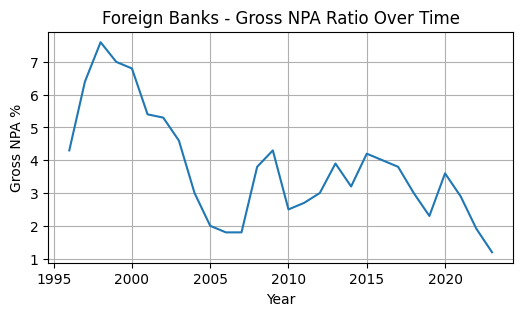

In [90]:
# Visually Identify Change-Point Detection (Foreign Banks)

plt.figure(figsize=(6,3))

plt.plot(foreign_df["Year"], foreign_df["Gross_NPA_pct_Gross_Adv"])

plt.title("Foreign Banks - Gross NPA Ratio Over Time")
plt.xlabel("Year")
plt.ylabel("Gross NPA %")

plt.grid(True)
plt.show()

In [91]:
# Statistical Change-Point Detection (Foreign Banks)

# Prepare the signal
signal_gross_foreign = foreign_df["Gross_NPA_pct_Gross_Adv"].values

# Change-point detection using PELT
algo_foreign = rpt.Pelt(model="rbf").fit(signal_gross_foreign)

# Detect breakpoints
# Penalty selected as the smallest value that yields stable and interpretable breakpoints
breakpoints_foreign_gross = algo_foreign.predict(pen=3)

breakpoints_foreign_gross

[5, 28]

In [49]:
foreign_df.iloc[5-1]["Year"]

np.int64(2000)

In [45]:
# Change-Point Detection (Net NPA)

signal_net_foreign = foreign_df["Net_NPA_pct_Net_Adv"].values
signal_net_foreign

array([1.9     , 2.2     , 2.9     , 2.4     , 1.8     , 1.9     ,
       1.7     , 1.5     , 0.8     , 0.8     , 0.7     , 0.8     ,
       1.8     , 1.8     , 0.7     , 0.6     , 1.      , 1.1     ,
       0.5     , 0.8     , 0.6     , 0.4     , 0.5     , 0.5     ,
       0.8     , 0.649372, 0.337231, 0.145675])

In [46]:
foreign_algo_net = rpt.Pelt(model="rbf").fit(signal_net_foreign)

breakpoints_foreign_net = foreign_algo_net.predict(pen=3)

breakpoints_foreign_net

[15, 28]

In [50]:
pvt_df.iloc[15-1]["Year"]

np.int64(2010)

##### Result
**Gross NPA:** Break detected around 2000.
**Net NPA:** Break detected around 2010.

##### Interpretation

- 2000: Shift in asset quality levels.
- 2010: Change in provisioning pattern.
- Possible link to global financial cycle adjustments.

#### 8. Key Findings

| Bank Group | Gross NPA Break Point | Net NPA Break Point | Interpretation |
|:--------------|------------:|----------:|:----------------------------|
| Public Sector Banks | 2000 | 2000 | Structural reset in asset quality |
| Private Banks | None | 2005 | Provisioning discipline improved |
| Foreign Banks | 2000 | 2010 | Global-cycle sensitivity |

#### 9. Key Insights
The 2015–2018 NPA spike does not qualify as a permanent structural regime shift under the selected model specification.
It appears as a severe but temporary stress episode.

### Methodological Conclusion
This analysis demonstrates that structural breaks in banking stress can be objectively identified using PELT. While traditional analysis focuses on annual growth rates, change-point detection reveals the underlying "regime" of a system. This framework can be applied to any time-series data where identifying a fundamental shift in behavior is critical for risk assessment.